# Interpolation in the Presence of Noisy Data

In this notebook, we provide a simple example demonstrating the effectiveness of interpolating models (in this case models that achieve 100% training accuracy in classification) even in the presence of incorrectly labelled data.  In particular, we use the Laplace kernel for image classification on MNIST.  We load the relevant subset of MNIST data below. 

In [12]:
# We will use a subset of MNIST for demonstrating double descent 
import torch
from torchvision import datasets, transforms


train_set = datasets.MNIST('./data', train=True, download=True)
test_set = datasets.MNIST('./data', train=False, download=True)

# Loading/Normalizing training & test images
train_imgs, train_labels = train_set.data / 256, train_set.targets
test_imgs, test_labels = test_set.data / 256, test_set.targets

classes = {}
max_per_class = 400
max_labels = 10

for idx, label in enumerate(train_labels): 
    label = label.data.numpy().item()
    if label in classes and len(classes[label]) < max_per_class: 
        classes[label].append(train_imgs[idx])
    elif label not in classes: 
        classes[label] = [train_imgs[idx]]
        
    if len(classes) >= max_labels:
        early_exit = True
        for label in classes: 
            early_exit &= len(classes[label]) >= max_per_class
        if early_exit: 
            break

all_train_examples = []
all_train_labels = []
for label in classes:
    label_vec = torch.zeros(max_labels)
    label_vec[label] = 1.
    all_train_examples.extend(classes[label])
    all_train_labels.extend([label_vec]*len(classes[label]))
    
all_test_labels = []    
for label in test_labels: 
    label = label.data.numpy().item()
    label_vec = torch.zeros(max_labels)
    label_vec[label] = 1.
    all_test_labels.append(label_vec)
    
    
train_set = torch.stack(all_train_examples, dim=0).view(max_labels * max_per_class, -1)
train_set = train_set / torch.norm(train_set, p=2, dim=1).view(-1, 1)
train_labels = torch.stack(all_train_labels, dim=0)

test_set = test_imgs.view(-1, 28*28)
test_set = test_set / torch.norm(test_set, p=2, dim=1).view(-1, 1) 
test_labels = torch.stack(all_test_labels, dim=0)

print("Train Set: ", train_set.shape)
print("Train Labels: ", train_labels.shape)
print("Test Set: ", test_set.shape)
print("Test Labels: ", test_labels.shape)

Train Set:  torch.Size([4000, 784])
Train Labels:  torch.Size([4000, 10])
Test Set:  torch.Size([10000, 784])
Test Labels:  torch.Size([10000, 10])


### Interpolation with EigenPro

Below we use the Laplace kernel to classify MNIST digits from pixels.  We make use of the EigenPro library (https://github.com/EigenPro/EigenPro-pytorch) below for solving kernel regression. 

probability: 0.00 & Number of labels corrupted: 0


/home/aradha/princeton_dl_tutorial/eigenpro.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=False).to(self.device)


SVD time: 0.69, top_q: 36, top_eigval: 0.90, new top_eigval: 5.20e-04
n_subsamples=2000, bs_gpu=2000, eta=1923.82, bs=1905, top_eigval=8.97e-01, beta=0.99
train error: 0.00%	val error: 4.58% (150 epochs, 1.47 seconds)	train l2: 1.57e-07	val l2: 1.44e-02
probability: 0.10 & Number of labels corrupted: 371
SVD time: 0.69, top_q: 36, top_eigval: 0.90, new top_eigval: 5.20e-04
n_subsamples=2000, bs_gpu=2000, eta=1923.82, bs=1905, top_eigval=8.97e-01, beta=0.99
train error: 0.00%	val error: 4.89% (150 epochs, 1.44 seconds)	train l2: 2.14e-06	val l2: 1.77e-02
probability: 0.20 & Number of labels corrupted: 805
SVD time: 0.70, top_q: 36, top_eigval: 0.90, new top_eigval: 5.20e-04
n_subsamples=2000, bs_gpu=2000, eta=1923.82, bs=1905, top_eigval=8.97e-01, beta=0.99
train error: 0.00%	val error: 5.56% (150 epochs, 1.44 seconds)	train l2: 5.00e-06	val l2: 2.27e-02
probability: 0.30 & Number of labels corrupted: 1204
SVD time: 0.69, top_q: 36, top_eigval: 0.90, new top_eigval: 5.20e-04
n_subsample

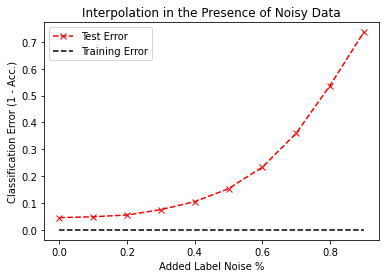

In [15]:
from numpy.linalg import pinv, solve
import numpy as np
import time 
import random
import matplotlib.pyplot as plt
%matplotlib inline

import kernel
import eigenpro
import torch

SEED = 2134
np.random.seed(SEED)
random.seed(SEED)

def mse(preds, labels): 
    return np.mean(np.abs(np.power(preds - labels, 2)))

def numpy_acc(preds, labels):
    preds_max = np.argmax(preds, axis=0)
    labels_max = np.argmax(labels, axis=0)
    return np.mean(preds_max == labels_max)


X = train_set.cpu().data.numpy().astype("float32")
y = train_labels.cpu().data.numpy().astype("float32")
X_test = test_set.cpu().data.numpy().astype("float32")
y_test = test_labels.cpu().data.numpy().astype("float32")

possible_labels = np.eye(10)
random_idxs = np.random.randint(low=0, high=10, size=len(y))
random_labels  = possible_labels[random_idxs, :]

random_test_idxs = np.random.randint(low=0, high=10, size=len(y_test))
random_test_labels  = possible_labels[random_test_idxs, :]

noise_probs = np.linspace(0, .9, 10)
train_errors = []
test_errors = []
for p in noise_probs:
    choice = np.random.uniform(size=y.shape[0])
    choice = np.where(choice < p, 1, 0)
    y[choice==1] = random_labels[choice==1]

    # Uncomment if you want to corrupt the labels for test data as well
    # choice_test = np.random.uniform(size=y_test.shape[0])
    # choice_test = np.where(choice_test < p, 1, 0)
    # y_test[choice_test==1] = random_test_labels[choice_test==1]
    
    print("probability: %.2f & Number of labels corrupted: %d"%(p, np.sum(choice)))    

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    n_class = 10
    num_epochs=150
    kernel_fn = lambda x,y: kernel.laplacian(x, y, bandwidth=10)
    model = eigenpro.FKR_EigenPro(kernel_fn, X, n_class, device=device)
    res = model.fit(X, y, X_test, y_test, epochs=[num_epochs], mem_gb=12)
    train_errors.append(1 - res[num_epochs][0]['multiclass-acc'])
    test_errors.append(1 - res[num_epochs][1]['multiclass-acc'])

plt.title("Interpolation in the Presence of Noisy Data")
plt.xlabel("Added Label Noise %")
plt.ylabel("Classification Error (1 - Acc.)")
plt.plot(noise_probs, test_errors, 'rx--', label='Test Error')
plt.plot(noise_probs, train_errors, 'k--', label='Training Error')
plt.legend()
plt.show()